In [1]:
import csv
import sys
sys.path.append("/home/yz19/")
import xray_yz.utils as xyzu
import xray_yz.functions as xyzf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path

import operator

ImportError: No module named xray_yz.utils

In [2]:
# load labelled set
PATH_TO_REPORTS_CSV = "/montana-storage02/chest_xrays/data_reports/ReportsForChestXBERT/yz_multilabel/reports.csv"
PATH_TO_REPORTS_LAB = "/montana-storage02/chest_xrays/data_reports/ReportsForChestXBERT/yz_multilabel/report_labels.npy"
labelled_reports = pd.read_csv(PATH_TO_REPORTS_CSV, sep = "$", names = ["id", "text"], header = 0)

t = np.stack(np.load(PATH_TO_REPORTS_LAB, allow_pickle = True))
num_samples = np.sum(t, axis = 0)

In [3]:
def get_label_index(c, class_list = xyzu.c):
    return np.argwhere(np.array(class_list) == c)[0, 0]

In [4]:
# create labels dict

labels_dict = dict()
for c in xyzu.c:
    labels_dict[c] = 0

print(labels_dict)

{'abnormal_non_clinically_important': 0, 'aortic_calcification': 0, 'apical_fibrosis': 0, 'atelectasis': 0, 'axillary_abnormality': 0, 'bronchial_wall_thickening': 0, 'bulla': 0, 'cardiomegaly': 0, 'cavitating_lung_lesion': 0, 'clavicle_fracture': 0, 'comparison': 0, 'consolidation': 0, 'coronary_calcification': 0, 'dextrocardia': 0, 'dilated_bowel': 0, 'emphysema': 0, 'ground_glass_opacification': 0, 'hemidiaphragm_elevated': 0, 'hernia': 0, 'hyperexpanded_lungs': 0, 'interstitial_shadowing': 0, 'left_lower_lobe_collapse': 0, 'left_upper_lobe_collapse': 0, 'mediastinum_displaced': 0, 'mediastinum_widened': 0, 'normal': 0, 'object': 0, 'other': 0, 'paraspinal_mass': 0, 'paratracheal_hilar_enlargement': 0, 'parenchymal_lesion': 0, 'pleural_abnormality': 0, 'pleural_effusion': 0, 'pneumomediastinum': 0, 'pneumoperitoneum': 0, 'pneumothorax': 0, 'possible_diagnosis': 0, 'recommendation': 0, 'rib_fracture': 0, 'rib_lesion': 0, 'right_lower_lobe_collapse': 0, 'right_middle_lobe_collapse': 0

In [5]:
# count presence of each label

counts = sum(t)

for i, c in enumerate(xyzu.c):
    labels_dict[c] = counts[i]
    
print(labels_dict)

{'abnormal_non_clinically_important': 845, 'aortic_calcification': 223, 'apical_fibrosis': 86, 'atelectasis': 810, 'axillary_abnormality': 8, 'bronchial_wall_thickening': 357, 'bulla': 225, 'cardiomegaly': 895, 'cavitating_lung_lesion': 208, 'clavicle_fracture': 221, 'comparison': 3519, 'consolidation': 1905, 'coronary_calcification': 13, 'dextrocardia': 199, 'dilated_bowel': 241, 'emphysema': 327, 'ground_glass_opacification': 243, 'hemidiaphragm_elevated': 313, 'hernia': 266, 'hyperexpanded_lungs': 393, 'interstitial_shadowing': 749, 'left_lower_lobe_collapse': 384, 'left_upper_lobe_collapse': 144, 'mediastinum_displaced': 322, 'mediastinum_widened': 222, 'normal': 5578, 'object': 2299, 'other': 1151, 'paraspinal_mass': 2, 'paratracheal_hilar_enlargement': 424, 'parenchymal_lesion': 421, 'pleural_abnormality': 522, 'pleural_effusion': 1376, 'pneumomediastinum': 181, 'pneumoperitoneum': 160, 'pneumothorax': 498, 'possible_diagnosis': 1469, 'recommendation': 951, 'rib_fracture': 349, '

<BarContainer object of 50 artists>

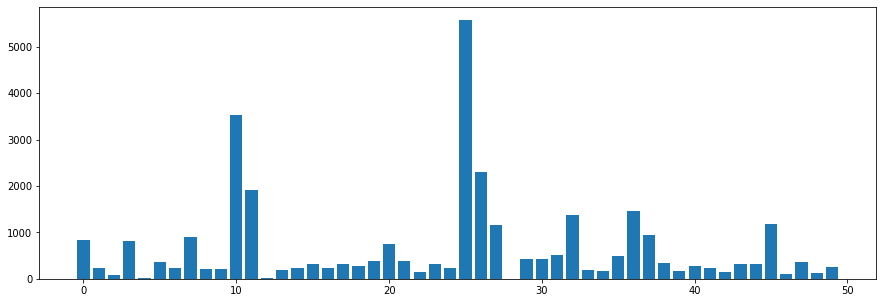

In [6]:
plt.figure(figsize = (15, 5))
plt.bar(range(50), labels_dict.values())

In [7]:
# don't have a collection object so creating dictionary where 
# k = label
# v = indices where label is true

label_indices = {}
for i, c in enumerate(xyzu.c):
    label_indices[c] = np.argwhere(t[:, i]).ravel()

In [8]:
n = 0 # number of currently selected reports
n_max = 200 # max number of reports to select
labels_selected = labels_dict.fromkeys(labels_dict, 0) # copy of labels dict with 0s
ids_selected = []

while n < n_max:
    labels_not_done = [] # labels still needed?
    labels_over = [] #labels with too many samples?
    
    for k, v in labels_selected.items():
        if v < labels_dict[k]:
            labels_not_done.append(k)
            
    reps_label_least = min(labels_selected.keys() & labels_not_done, key = labels_selected.get)
    
    for k, v in labels_selected.items():
        if v >= labels_selected[reps_label_least] + 3: #probably need to tune this value
            labels_over.append(k)
    
    print("least represented label is {}".format(reps_label_least))
    print("over-represented label(s): {}\n".format(labels_over))
    
    no_report = True
    rep_in = reps_label_least
    if labels_over == []:
        rep_notin = []
    else:
        rep_notin = np.unique(np.hstack(label_indices[x] for x in labels_over))

    # loop to add one report
    for i, xid in enumerate(labelled_reports.id):
        # skip reports already selected
        if not xid in ids_selected:

            # get first report that is in in and not in notin
            if i in label_indices[rep_in]:
                candidate_if_no_report = i
                if not i in rep_notin:
                    ids_selected.append(xid) # append to list of selected

                    # increase appropriate counters
                    labels_to_increase = np.argwhere(t[i, :]).ravel()
                    for i in labels_to_increase:
                        labels_selected[xyzu.c[i]] += 1            
                    n += 1 
                    no_report = False

                    break

                else:
                    continue
            else: 
                continue

    if no_report:
        print("==========================================================")
        print("not considering whether a label already has enough samples")
        print("==========================================================")

        ids_selected.append(labelled_reports.id[candidate_if_no_report])

        labels_to_increase = np.argwhere(t[candidate_if_no_report, :]).ravel()
        for i in labels_to_increase:
            labels_selected[xyzu.c[i]] += 1

        n += 1     
    print("number of total reports: {}".format(n))
    



least represented label is interstitial_shadowing
over-represented label(s): []

number of total reports: 1
least represented label is rib_lesion
over-represented label(s): []

number of total reports: 2
least represented label is mediastinum_widened
over-represented label(s): []

number of total reports: 3
least represented label is clavicle_fracture
over-represented label(s): ['possible_diagnosis']

number of total reports: 4
least represented label is upper_lobe_blood_diversion
over-represented label(s): ['possible_diagnosis']

number of total reports: 5
least represented label is hyperexpanded_lungs
over-represented label(s): ['possible_diagnosis']

number of total reports: 6
least represented label is aortic_calcification
over-represented label(s): ['normal', 'possible_diagnosis']

number of total reports: 7
least represented label is bulla
over-represented label(s): ['normal', 'pleural_effusion', 'possible_diagnosis']

number of total reports: 8
least represented label is left_up

/home/yz19/anaconda3/envs/nlptest/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


not considering whether a label already has enough samples
number of total reports: 34
least represented label is scoliosis
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'interstitial_shadowing', 'normal', 'object', 'possible_diagnosis', 'recommendation', 'technical_issue']

number of total reports: 35
least represented label is hemidiaphragm_elevated
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'interstitial_shadowing', 'normal', 'object', 'pleural_effusion', 'possible_diagnosis', 'recommendation', 'technical_issue']

number of total reports: 36
least represented label is apical_fibrosis
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'interstitial_shadowing', 'normal', 'object', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommend

number of total reports: 59
least represented label is dilated_bowel
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'hyperexpanded_lungs', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'rib_lesion', 'technical_issue', 'volume_loss']

not considering whether a label already has enough samples
number of total reports: 60
least represented label is coronary_calcification
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'hyperexpanded_lungs', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'rib_lesion', 'technical_issue', 'volume_loss']

not considering whether a label 

not considering whether a label already has enough samples
number of total reports: 80
least represented label is dilated_bowel
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'emphysema', 'hernia', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'paratracheal_hilar_enlargement', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'technical_issue', 'volume_loss']

not considering whether a label already has enough samples
number of total reports: 81
least represented label is coronary_calcification
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'emphysema', 'hernia', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'paratracheal_hilar_enlargement', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possibl

not considering whether a label already has enough samples
number of total reports: 99
least represented label is rib_lesion
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'interstitial_shadowing', 'normal', 'object', 'other', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'technical_issue', 'volume_loss']

number of total reports: 100
least represented label is mediastinum_widened
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'interstitial_shadowing', 'normal', 'object', 'other', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'technical_issue', 'volume_loss']

not considering whether a label already has enough samples
number of total reports: 101
least represented label is clavicle_fracture
over-represented label(s): ['abnor

not considering whether a label already has enough samples
number of total reports: 117
least represented label is dilated_bowel
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'emphysema', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'parenchymal_lesion', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'rib_lesion', 'technical_issue', 'volume_loss']

not considering whether a label already has enough samples
number of total reports: 118
least represented label is coronary_calcification
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'emphysema', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'parenchymal_lesion', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendatio

not considering whether a label already has enough samples
number of total reports: 133
least represented label is dextrocardia
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'parenchymal_lesion', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'rib_lesion', 'technical_issue']

not considering whether a label already has enough samples
number of total reports: 134
least represented label is bronchial_wall_thickening
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'parenchymal_lesion', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'rib_lesion', 'technical_issue']

n

not considering whether a label already has enough samples
number of total reports: 150
least represented label is dextrocardia
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'emphysema', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'parenchymal_lesion', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'rib_fracture', 'rib_lesion', 'technical_issue', 'unfolded_aorta']

not considering whether a label already has enough samples
number of total reports: 151
least represented label is bronchial_wall_thickening
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'emphysema', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'parenchymal_lesion', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagn

not considering whether a label already has enough samples
number of total reports: 164
least represented label is ground_glass_opacification
over-represented label(s): ['abnormal_non_clinically_important', 'cardiomegaly', 'comparison', 'consolidation', 'emphysema', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'parenchymal_lesion', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'technical_issue', 'unfolded_aorta']

not considering whether a label already has enough samples
number of total reports: 165
least represented label is right_upper_lobe_collapse
over-represented label(s): ['abnormal_non_clinically_important', 'cardiomegaly', 'comparison', 'consolidation', 'emphysema', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'parenchymal_lesion', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'technical_issue', 'u

not considering whether a label already has enough samples
number of total reports: 178
least represented label is undefined_sentence
over-represented label(s): ['abnormal_non_clinically_important', 'cardiomegaly', 'comparison', 'consolidation', 'emphysema', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'parenchymal_lesion', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'technical_issue', 'unfolded_aorta']

not considering whether a label already has enough samples
number of total reports: 179
least represented label is scoliosis
over-represented label(s): ['abnormal_non_clinically_important', 'cardiomegaly', 'comparison', 'consolidation', 'emphysema', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'parenchymal_lesion', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'technical_issue', 'unfolded_aorta']

not con

not considering whether a label already has enough samples
number of total reports: 192
least represented label is mediastinum_widened
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'emphysema', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'parenchymal_lesion', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'technical_issue']

not considering whether a label already has enough samples
number of total reports: 193
least represented label is clavicle_fracture
over-represented label(s): ['abnormal_non_clinically_important', 'atelectasis', 'cardiomegaly', 'comparison', 'consolidation', 'emphysema', 'interstitial_shadowing', 'left_lower_lobe_collapse', 'normal', 'object', 'other', 'parenchymal_lesion', 'pleural_abnormality', 'pleural_effusion', 'pneumothorax', 'possible_diagnosis', 'recommendation', 'technical_issue']

not 

In [9]:
labels_selected

{'abnormal_non_clinically_important': 31,
 'aortic_calcification': 11,
 'apical_fibrosis': 10,
 'atelectasis': 14,
 'axillary_abnormality': 8,
 'bronchial_wall_thickening': 10,
 'bulla': 11,
 'cardiomegaly': 27,
 'cavitating_lung_lesion': 11,
 'clavicle_fracture': 11,
 'comparison': 62,
 'consolidation': 35,
 'coronary_calcification': 10,
 'dextrocardia': 10,
 'dilated_bowel': 10,
 'emphysema': 13,
 'ground_glass_opacification': 10,
 'hemidiaphragm_elevated': 11,
 'hernia': 11,
 'hyperexpanded_lungs': 11,
 'interstitial_shadowing': 25,
 'left_lower_lobe_collapse': 14,
 'left_upper_lobe_collapse': 11,
 'mediastinum_displaced': 12,
 'mediastinum_widened': 11,
 'normal': 119,
 'object': 30,
 'other': 43,
 'paraspinal_mass': 2,
 'paratracheal_hilar_enlargement': 12,
 'parenchymal_lesion': 15,
 'pleural_abnormality': 15,
 'pleural_effusion': 27,
 'pneumomediastinum': 10,
 'pneumoperitoneum': 10,
 'pneumothorax': 14,
 'possible_diagnosis': 52,
 'recommendation': 27,
 'rib_fracture': 12,
 'ri

<BarContainer object of 50 artists>

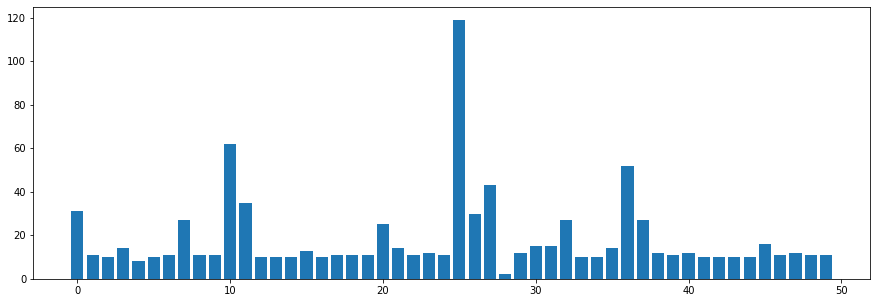

In [10]:
plt.figure(figsize = (15, 5))
plt.bar(range(50), labels_selected.values())

In [12]:
np.save("ids_UNIF_200.npy", ids_selected, allow_pickle = True)

In [13]:
import numpy as np
aux = list(np.load("ids_UNIF_200.npy").astype(np.string_))

In [15]:
# used to generate the inserts in ax_report_collection
aux

['1014229',
 '1037268',
 '1063109',
 '1046393',
 '1013343',
 '113351',
 '1433638',
 '1045095',
 '1047157',
 '1725414',
 '1259576',
 '1147420',
 '1167141',
 'X-07245153',
 '1071490',
 'X-07298159',
 'RJ108847858',
 'X-06292161',
 'RJ107789471',
 'RJ107810376',
 '1733873',
 '2425763',
 '1429528',
 '2442993',
 '577285',
 'X-06412037',
 '1074288',
 '1113607',
 '2067834',
 '985987',
 'RJ107517915',
 '997988',
 'RJ109546019',
 '595075',
 'X-06451570',
 'RJ107633638',
 '200034',
 '962488',
 'RJ107553064',
 '81571',
 'X-06319032',
 'RJ107916662',
 '2198465',
 '987028',
 '944883',
 '1700087',
 '981207',
 '997728',
 '986130',
 'RJ108437891',
 '956088',
 '953398',
 '1206992',
 '893688',
 '983987',
 'RJ107951112',
 'X-05877030',
 '933899',
 '1435436',
 '2752177',
 '1203045',
 'RJ108512115',
 '2497908',
 '977333',
 'RJ107795609',
 '968738',
 '335267',
 '228367',
 '602379',
 'X-05935326',
 '951129',
 '838980',
 'X-07152013',
 '779114',
 '532768',
 '857359',
 '990946',
 'RJ108628932',
 '780452',
 '94